In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore, pearsonr
import seaborn as sns

In [53]:
df_items = pd.read_parquet('./src/cleaned/items.parquet', engine='fastparquet')
df_reviews = pd.read_parquet('./src/cleaned/reviews.parquet' , engine='fastparquet')
df_users = pd.read_parquet('./src/cleaned/users.parquet' , engine='fastparquet')
df_games = pd.read_parquet('./src/cleaned/games.parquet' , engine='fastparquet')
df_genres = pd.read_parquet('./src/cleaned/genres.parquet' , engine='fastparquet')

## Cantidad de horas jugadas por cada usuario

In [54]:
#Tiempo total de juego por usuario
df_total_time = df_items.groupby('user_id').agg({'playtime_forever':'sum'}).reset_index().sort_values(by='playtime_forever', ascending=True)

In [55]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [56]:
df_total_time.describe()

,playtime_forever
count,70912.00
mean,72052.43
std,90694.19
min,0.00
25%,11518.00
50%,44350.50
75%,101920.00
max,4660393.00


In [57]:
df_total_time['playtime_forever'].median()

44350.5

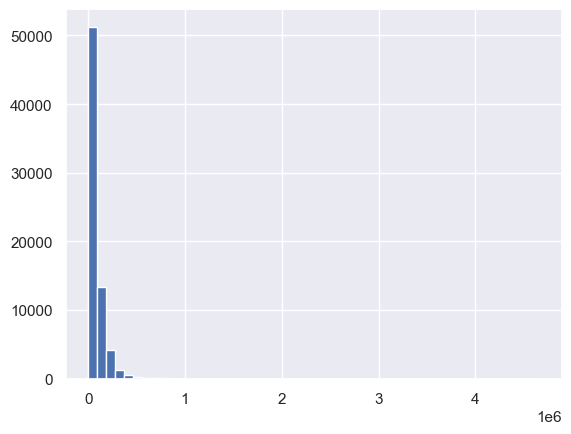

In [58]:
plt.hist(df_total_time['playtime_forever'], bins=50);

In [59]:
#Eliminamos los outliers
df_total_time = df_total_time.loc[(np.abs(zscore(df_total_time['playtime_forever'])) < 3)]

In [60]:
df_total_time.describe()

,playtime_forever
count,69822.00
mean,65710.24
std,69320.70
min,0.00
25%,11143.00
50%,43089.00
75%,98036.25
max,343991.00


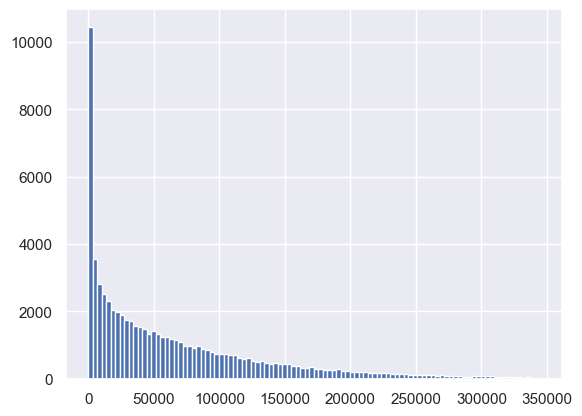

In [61]:
plt.hist(df_total_time['playtime_forever'], bins=100);

## Relación entre metascore y reviews positivas o negativas

In [62]:
#Creamos las columnas con la suma de reviews de cada tipo
good_reviews_by_game = df_reviews.loc[df_reviews['sentiment_analysis'] == 2].groupby('item_id').agg({'sentiment_analysis':'count'}).reset_index()\
.rename(columns={'sentiment_analysis':'good_reviews'})

neutral_reviews_by_game = df_reviews.loc[df_reviews['sentiment_analysis'] == 1].groupby('item_id').agg({'sentiment_analysis':'count'}).reset_index()\
.rename(columns={'sentiment_analysis':'neutral_reviews'})

bad_reviews_by_game = df_reviews.loc[df_reviews['sentiment_analysis'] == 0].groupby('item_id').agg({'sentiment_analysis':'count'}).reset_index()\
.rename(columns={'sentiment_analysis':'bad_reviews'})



In [63]:
#Unimos las columnas al dataframe de juegos
games_with_reviews = pd.merge(df_games, good_reviews_by_game, left_on='id', right_on='item_id', how='left')
games_with_reviews = pd.merge(games_with_reviews, neutral_reviews_by_game, on='item_id', how='left')
games_with_reviews = pd.merge(games_with_reviews, bad_reviews_by_game, on='item_id', how='left')

#Imputamos 0 a los juegos que no tienen reviews
games_with_reviews[['good_reviews', 'neutral_reviews', 'bad_reviews']] = games_with_reviews[['good_reviews', 'neutral_reviews', 'bad_reviews']].fillna(0)

In [64]:
games_with_reviews['metascore'].sort_values(ascending=True).head(10)

1439    20.00
829     24.00
22677   27.00
23271   29.00
23418   30.00
19772   32.00
20218   32.00
21609   33.00
593     34.00
1919    35.00
Name: metascore, dtype: float64

c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype

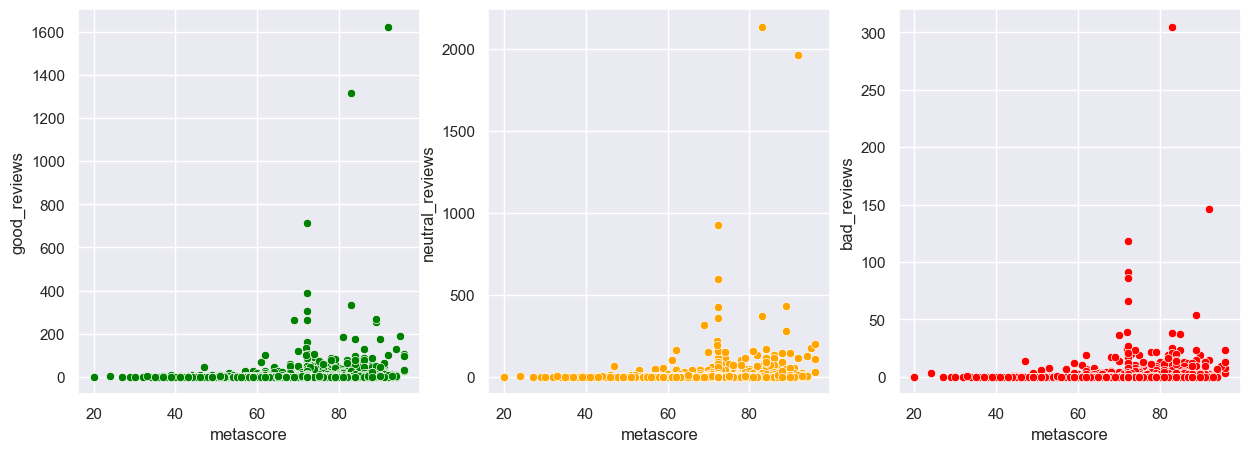

In [65]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

sns.scatterplot(data=games_with_reviews, x='metascore', y='good_reviews', ax=axes[0], color='green')
sns.scatterplot(data=games_with_reviews, x='metascore', y='neutral_reviews', ax=axes[1], color='orange')
sns.scatterplot(data=games_with_reviews, x='metascore', y='bad_reviews', ax=axes[2], color='red')

plt.show()

El tipo de reviews no parece estar relacionado con el metascore, pero posiblemente sí su cantidad total con la popularidad del juego. El pico al rededor del score 72.24 se debe a haber
imputado el promedio a aquelllos juegos que no tienen metascore 

## Cantidad de jugadores por juego

In [74]:
total_users_by_game = df_items.groupby('item_id').agg({'user_id':'count'}).reset_index().rename(columns={'user_id':'total_players'})
total_users_by_game = pd.merge(df_games, total_users_by_game,left_on='id', right_on='item_id', how='left').drop(columns='item_id')
total_users_by_game['total_players'].fillna(0, inplace=True)
total_users_by_game = pd.merge(total_users_by_game, games_with_reviews, left_on='id', right_on='id', how='left', suffixes=('', '_remove')).drop(columns='item_id')
total_users_by_game.drop([i for i in total_users_by_game.columns if 'remove' in i], axis=1, inplace=True)
total_users_by_game['total_reviews'] = total_users_by_game['good_reviews'] + total_users_by_game['neutral_reviews'] + total_users_by_game['bad_reviews']
total_users_by_game['total_reviews'].fillna(0, inplace=True)
total_users_by_game['metascore'].fillna(total_users_by_game['metascore'].mean(), inplace=True)
total_users_by_game.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23794 entries, 0 to 23793
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genres           23794 non-null  object 
 1   app_name         23794 non-null  object 
 2   title            23794 non-null  object 
 3   release_date     23794 non-null  int32  
 4   tags             23794 non-null  object 
 5   specs            23794 non-null  object 
 6   price            23794 non-null  float64
 7   id               23794 non-null  Int64  
 8   metascore        23794 non-null  float64
 9   total_players    23794 non-null  float64
 10  good_reviews     23794 non-null  Int64  
 11  neutral_reviews  23794 non-null  Int64  
 12  bad_reviews      23794 non-null  Int64  
 13  total_reviews    23794 non-null  Int64  
dtypes: Int64(5), float64(3), int32(1), object(5)
memory usage: 2.6+ MB


c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='metascore', ylabel='total_players'>

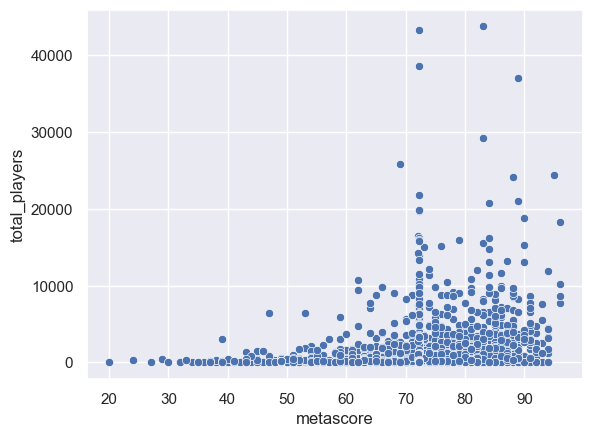

In [76]:
sns.scatterplot(data=total_users_by_game, x='metascore', y='total_players')

c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='total_reviews', ylabel='total_players'>

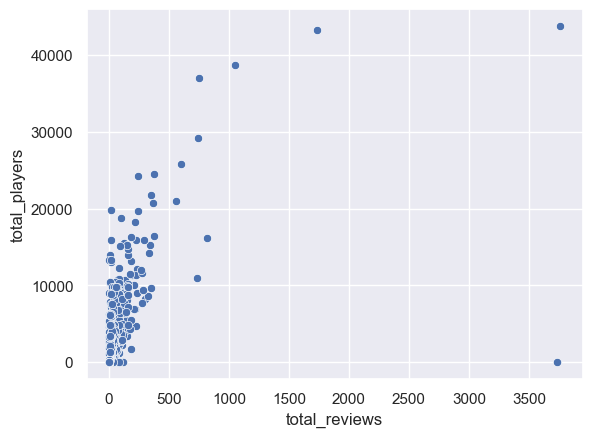

In [77]:
sns.scatterplot(data=total_users_by_game, x='total_reviews', y='total_players')

In [78]:
print(pearsonr(total_users_by_game['metascore'], total_users_by_game['total_players']))
print(pearsonr(total_users_by_game['total_reviews'], total_users_by_game['total_players']))
print(pearsonr(total_users_by_game['good_reviews'].fillna(0), total_users_by_game['total_players'], ))
print(pearsonr(total_users_by_game['neutral_reviews'].fillna(0), total_users_by_game['total_players']))
print(pearsonr(total_users_by_game['bad_reviews'].fillna(0), total_users_by_game['total_players']))

PearsonRResult(statistic=0.1838139611789096, pvalue=7.459317236169874e-180)
PearsonRResult(statistic=0.5585477283995094, pvalue=0.0)
PearsonRResult(statistic=0.5543657707632208, pvalue=0.0)
PearsonRResult(statistic=0.549975796099785, pvalue=0.0)
PearsonRResult(statistic=0.5766268535547987, pvalue=0.0)


Podemos ver que el metascore está muy poco relacionado con la cantidad de jugadores, mientras que la cantidad de reviews, de manera predecible, sí lo está. 

c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\o0o0o0o\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='total_players', ylabel='price'>

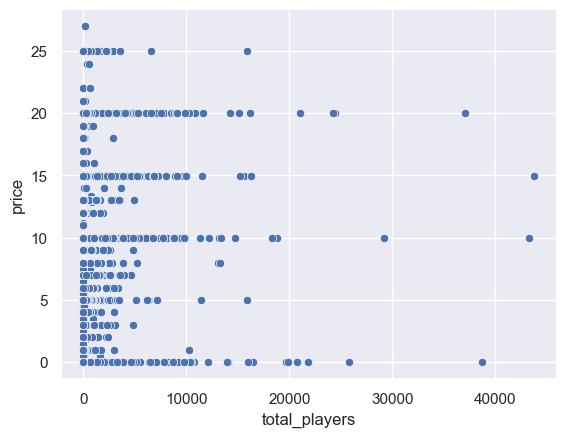

In [83]:
#Quitamos outliers en el precio
total_users_by_game = total_users_by_game.loc[(np.abs(zscore(total_users_by_game['price'])) < 3)]
sns.scatterplot(data=total_users_by_game, x='price', y='total_players')

In [84]:
pearsonr(total_users_by_game['price'], total_users_by_game['total_players'])

PearsonRResult(statistic=0.08257423197264478, pvalue=1.6527900936807804e-35)

El precio tampoco parece estar relacionado con la cantidad de jugadores

## Géneros

In [224]:
items_time_played = df_items.groupby('item_id')['playtime_forever'].agg(['sum', 'mean']).reset_index().rename(columns={'sum':'total_time_played', 'mean':'mean_time_played_by_user'})
# games_with_genre = pd.merge(df_items, df_games[['id', 'genres']], left_on='item_id', right_on='id', how='left').drop(columns='item_id')
# games_with_genre = pd.merge(games_with_genre, items_time_played, left_on='id', right_on='item_id', how='left').drop(columns='item_id')
games_with_genre = pd.merge(df_games[['id', 'genres', 'title']], items_time_played, left_on='id', right_on='item_id', how='left').drop(columns='item_id')
games_with_genre['mean_time_played_by_user'].fillna(0, inplace=True)
games_with_genre['total_time_played'].fillna(0, inplace=True)
games_with_genre.dropna(subset='genres',inplace=True)


In [225]:
games_with_genre['genres'] = games_with_genre['genres'].astype(str).str.replace('[', '').str.replace(']', '').str.replace("'", '').str.split(', ')

In [226]:
games_with_genre = games_with_genre.explode('genres')


In [227]:
games_with_genre['genres'].unique()

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy',
       'Free to Play', 'RPG', 'Sports', 'Adventure', 'Racing',
       'Massively Multiplayer', 'Early Access', 'None',
       'Animation & Modeling', 'Video Production', 'Web Publishing',
       'Education', 'Software Training', 'Utilities',
       'Design & Illustration', 'Audio Production', 'Photo Editing',
       'Accounting'], dtype=object)

In [228]:
time_by_genre = games_with_genre.groupby('genres').agg({'total_time_played':['sum', 'mean'], 'mean_time_played_by_user': ['sum', 'mean']}).reset_index().rename(columns={'sum':'total_time_played', 'mean':'mean_time_played'})

In [229]:
time_by_genre = games_with_genre.groupby('genres').agg(total_of_genre = ('total_time_played', 'sum'), mean_of_genre = ('total_time_played', 'mean'), \
    mean_of_games_by_user = ('mean_time_played_by_user', 'mean')).reset_index()

In [232]:
time_by_genre.sort_values(by='mean_of_games_by_user', ascending=False).head(10)

,genres,total_of_genre,mean_of_genre,mean_of_games_by_user
21,Video Production,2370030.00,28554.58,631.11
20,Utilities,4136063.00,16544.25,296.93
3,Animation & Modeling,2007347.00,14441.35,157.14
11,Massively Multiplayer,426073290.00,482529.21,139.83
13,Photo Editing,115425.00,2885.62,136.86
14,RPG,1019641466.00,251576.97,135.94
4,Audio Production,517140.00,6988.38,121.08
16,Simulation,866882836.00,178775.59,110.77
18,Sports,63882138.00,59926.96,108.31
19,Strategy,658512722.00,122150.38,106.77


Es destacable que de los productos disponibles en steam, la mitad de los que acumulan más horas promedio por usuario no sean juegos, sino software de edición de video, audio, etc.